In [2]:
# !pip install zarr
# !pip install botorch
# !pip install pyDOE

In [3]:
import numpy as np
import pandas as pd
# from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import warnings
import shutil

warnings.filterwarnings("ignore")

/data/zhq7531/envs/gamma/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

class FourierSeriesGenerator_10:

    def __init__(self, total_time=400, time_step=0.002):
        self.default_total_time = total_time
        self.default_time_step = time_step

    @staticmethod
    def _normalize(x):
        return 2 * (x - np.min(x)) / (np.max(x) - np.min(x)) - 1

    @staticmethod
    def _rescale(x, min_value, max_value):
        return x * (max_value - min_value) + min_value

    def fourier_series(self, x, params, rescale_mag=600, rescale_amplitude=50):
        x = self._normalize(x)

        n, freq, amplitude, phase, trend, seasonality, frequency_slope, amplitude_slope, phase_slope, seasonality_freq = params
        n = int(self._rescale(n, 0, 10))
        freq = self._rescale(freq, 0, 10)
        amplitude = self._rescale(amplitude, 0, 10)
        phase = self._rescale(phase, 0, 10000)
        trend = self._rescale(trend, -500, 500)
        seasonality = self._rescale(seasonality, 0, 500)
        frequency_slope = self._rescale(frequency_slope, -1.25, 1.25)
        amplitude_slope = self._rescale(amplitude_slope, -1.25, 1.25)
        phase_slope = self._rescale(phase_slope, -1.25, 1.25)
        seasonality_freq = self._rescale(seasonality_freq, -1, 1)  # Rescale it as per your requirement

        sum = np.zeros_like(x)
        for i in range(1, n + 1, 2):
            term = (1 / i) * np.sin(2 * np.pi * (freq + i * frequency_slope) * i * x + (phase + i * phase_slope))
            sum += term

        y = (amplitude + n * amplitude_slope) * (2 / np.pi) * sum
        if np.sum(y) == 0:
            return np.zeros_like(x) + 600
        else:
            y = (y - np.min(y)) / (np.max(y) - np.min(y))
            y = (y * rescale_amplitude) + rescale_mag

        y += trend * x
        y += seasonality * np.sin(2 * np.pi * seasonality_freq * x)

        y = (y - np.min(y)) / (np.max(y) - np.min(y)) # Normalize to [0,1]
        y = self._rescale(y, 400, 700) # Rescale to [400,700] due to practical reasons of the laser power profile
        return y

    def plot_and_save(self, params, base_path, iteration, total_time=None, time_step=None,
                      plot_title=None, figsize=(8, 6), xticks=None, yticks=None):
        if total_time is None:
            total_time = self.default_total_time
        if time_step is None:
            time_step = self.default_time_step

        folder_name = f"Iteration_{iteration}"
        save_directory = os.path.join(base_path, folder_name)
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)  # Create directory if it doesn't exist

        x = np.linspace(0, total_time, int(total_time / time_step))
        y = self.fourier_series(x, params)
        # Ensure y values are in the range [400, 700]
        y = (y - np.min(y)) / (np.max(y) - np.min(y)) # Normalize to [0,1]
        y = self._rescale(y, 400, 700) # Rescale to [400,700] due to practical reasons of the laser power profile

        plt.figure(figsize=figsize)

        # Create a plot
        plt.plot(x[:140000], y[:140000])

        # Add title if available
        if plot_title:
            plt.title(plot_title, fontsize=20)

        # Add x and y labels
        plt.xlabel("Time (Seconds)", fontsize=20)
        plt.ylabel("Laser Power as Time \n Series Profile", fontsize=20)

        # Use provided xticks and yticks if available
        if xticks is not None:
            plt.xticks(xticks)
        if yticks is not None:
            plt.yticks(yticks)

        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.title("Iteration 50", fontsize=20)

        # Add legend
        plt.legend()

        image_path = os.path.join(save_directory, "plot.png")
        plt.savefig(image_path)
        plt.show()

        output_string = "laser_power,time_elapsed\n"
        for i in range(len(x)):
            output_string += f"{y[i]:.15f},{x[i]:.2f}\n"
        csv_path = os.path.join(save_directory, "data.csv")
        with open(csv_path, "w") as f:
            f.write(output_string)

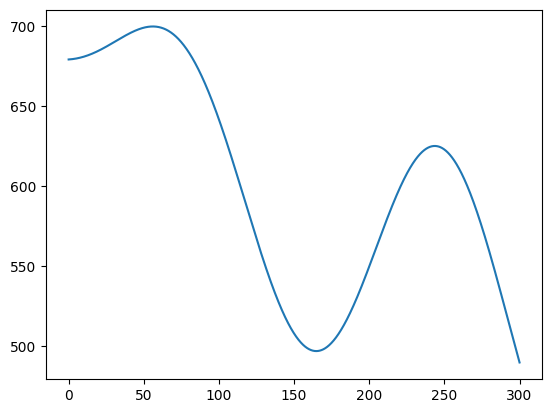

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming FourierSeriesGenerator_10 is defined or imported somewhere before this
x = np.linspace(0, 400, int(400 / 0.002))
fourier_gen = FourierSeriesGenerator_10(total_time=400, time_step=0.002)

Laser_power = fourier_gen.fourier_series(x, [0.11, 0.16, 0.69, 0.70, 0.41, 0.09, 0.39, 0.73, 0.16, 0.97])[:150000]

plt.plot(x[:150000], Laser_power)
plt.show()

df = pd.DataFrame({
    "Tim_Step": x[:150000],
    "Laser_power": Laser_power
})
df.to_csv("Optimal_Laser_Power.csv", index=False)


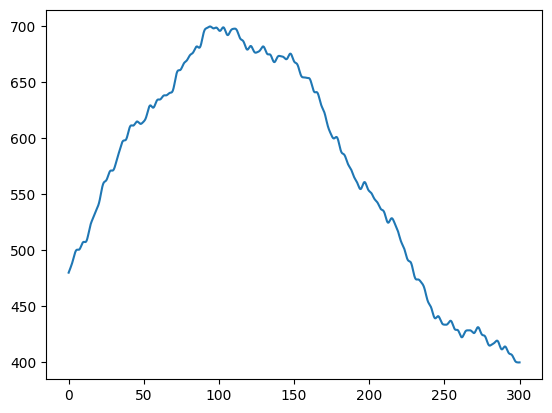

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming FourierSeriesGenerator_10 is defined or imported somewhere before this
x = np.linspace(0, 400, int(400 / 0.002))
fourier_gen = FourierSeriesGenerator_10(total_time=400, time_step=0.002)

Laser_power = fourier_gen.fourier_series(x,   [1.,         0.31369773, 0.16385065, 0.1689344,  0.5357304,  0.5076246,
 0.58220387, 0.44922945, 0.81219506, 0.2288186 ])[:150000]

plt.plot(x[:150000], Laser_power)
plt.show()

df = pd.DataFrame({
    "Tim_Step": x[:150000],
    "Laser_power": Laser_power
})
df.to_csv("Optimal_Laser_Power.csv", index=False)



In [7]:
import numpy as np

class TimeSeriesSimulator:
    def __init__(self):
        # Initialize with any necessary parameters
        pass

    def process_time_series(self, time_series):
        # Process the time series using a combination of advanced techniques
        # For demonstration, I'll use a simple mathematical operation with list comprehension
        # You can replace this with any complex operation as per your requirement
        processed_series = [np.sin(x) + np.cos(x) for x in time_series]
        return processed_series

    def calculate_output(self, processed_series):
        # Calculate a single output value from the processed series
        # For example, we could return the mean of the processed series
        return np.sum(processed_series)

    def simulate(self, time_series):
        # The main method to run the simulation
        processed = self.process_time_series(time_series)
        output = self.calculate_output(processed)
        return output

# Example usage
simulator = TimeSeriesSimulator()
time_series_data = np.linspace(0, 10, 100)  # Example time series data
result = simulator.simulate(time_series_data)
print(f"Output Value: {result}")


Output Value: 12.618549868083539


In [8]:
params = [1,         0.31369773, 0, 0.1689344,  0.5357304,  0.5076246,
 0.58220387, 0.44922945, 0.81219506, 0.2288186 ]

def objective(params):
    # Create an instance of the simulator with the given parameters
    x = np.linspace(0, 400, int(400 / 0.002))
    fourier_gen = FourierSeriesGenerator_10(total_time=400, time_step=0.002)
    Laser_power = fourier_gen.fourier_series(x, params)
    result = simulator.simulate(Laser_power)
    # Since Bayesian Optimization typically minimizes,
    # if you want to maximize the output, return the negative of the result
    return torch.tensor(-result)

objective(params)

tensor(1614.9919, dtype=torch.float64)

In [9]:
def initialize_model():
    train_X = pd.read_excel("optimized_params1.xlsx")
    train_X_np = train_X[["n", "freq", "amplitude", "phase", "trend", "seasonality", "frequency_slope", "amplitude_slope", "phase_slope", "Frequnecy of slope"]].values
    train_X_torch = torch.tensor(train_X_np, dtype=torch.float32)
    train_Y = pd.read_excel("avg_heat_treatment_times.xlsx")
    train_Y_np = train_Y[["Average Heat Treatment Time"]].values
    train_Y_torch = torch.tensor(train_Y_np, dtype=torch.float32)
    gp = SingleTaskGP(train_X_torch.float(), train_Y_torch.float())
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    return gp

In [10]:
def initialize_model(initial_data=None):
    """
    Initialize the Gaussian Process model.
    If initial_data is provided, it should be a tuple of (initial_params, initial_values).
    """
    if initial_data:
        train_X, train_Y = initial_data
        train_X = torch.tensor(train_X.astype(np.float32))
        train_Y = torch.tensor(train_Y.astype(np.float32)).unsqueeze(-1)
    else:
        # Define some initial data if none is provided
        # Here, you need to replace it with your actual initial data
        train_X = torch.rand((10, 10))  # Replace with actual number of parameters
        train_Y = torch.rand((10, 1))

    gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    return gp


In [11]:
def optimize(bounds, n_steps=50):
    gp = initialize_model()
    best_value = -float('inf')
    best_params = None

    param_history = []
    value_history = []
    uncertainty_history = []

    # Create an empty dataframe with the required columns
    df = pd.DataFrame(columns=['Parameters', 'Objective Value', 'Uncertainty'])

    for i in tqdm(range(n_steps)):
        UCB = UpperConfidenceBound(gp, beta=0.5)
        candidate, _ = optimize_acqf(UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20)
        candidate_numpy = candidate.detach().numpy().flatten()
        new_Y = objective(candidate_numpy).unsqueeze(0).unsqueeze(-1)


        variance = gp.posterior(candidate).variance
        uncertainty_history.append(variance.item())

        print(new_Y)
        #print(candidate_numpy)


        if new_Y.item() > best_value:
            best_value = new_Y.item()
            best_params = candidate_numpy

        param_history.append(candidate_numpy)
        value_history.append(new_Y.item())

        # Update the Gaussian Process model
        gp = SingleTaskGP(
            torch.cat([gp.train_inputs[0], torch.tensor(candidate_numpy.astype(np.float32)).unsqueeze(0)]),
            torch.cat([gp.train_targets.unsqueeze(-1).float(), new_Y.float()], dim=0)
        )
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        # Save the current iteration results to the dataframe
        #df = df.append({
        #    'Current Best Parameters': best_params,
        #    'Current Best Value': best_value,
        #    'Parameters': candidate_numpy.tolist(),
        #    'Objective Value': new_Y.item(),
        #    'Uncertainty': variance.item()
        #}, ignore_index=True)

        # Save the dataframe to an Excel file
        #df.to_csv('bayesian_optimization_results.csv', index=False)

    return gp, best_params, best_value, param_history, value_history, uncertainty_history

In [12]:
input_size = 10  # Assuming 10 parameters
bounds = torch.tensor([[0]*input_size, [1]*input_size], dtype=torch.float32)
optimized_model, best_params, best_value, param_history, value_history, uncertainty_history = optimize(bounds)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda7a6d3a30>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


  0%|          | 0/50 [00:00<?, ?it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50364160>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolIn

tensor([[-29.6239]], dtype=torch.float64)


  2%|▏         | 1/50 [00:00<00:41,  1.18it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50364dc0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thre

tensor([[-7703.4286]], dtype=torch.float64)


  4%|▍         | 2/50 [00:02<00:56,  1.17s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50364ca0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thre

tensor([[-6791.3215]], dtype=torch.float64)


  6%|▌         | 3/50 [00:03<01:05,  1.39s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50364dc0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thre

tensor([[190968.2061]], dtype=torch.float64)


  8%|▊         | 4/50 [00:05<01:00,  1.31s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50364040>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thre

tensor([[190968.2061]], dtype=torch.float64)


 10%|█         | 5/50 [00:07<01:12,  1.62s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda503644c0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thre

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda503663b0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.

tensor([[190968.2061]], dtype=torch.float64)


 14%|█▍        | 7/50 [00:09<00:56,  1.32s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50366050>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thre

tensor([[190968.2061]], dtype=torch.float64)


 16%|█▌        | 8/50 [00:10<00:50,  1.21s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50366f80>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thre

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda503669e0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


tensor([[190968.2061]], dtype=torch.float64)


 20%|██        | 10/50 [00:12<00:43,  1.09s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50367ac0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


 22%|██▏       | 11/50 [00:13<00:40,  1.03s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda2ceb40d0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


 24%|██▍       | 12/50 [00:13<00:36,  1.03it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50366a70>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50365fc0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


tensor([[190968.2061]], dtype=torch.float64)


 28%|██▊       | 14/50 [00:15<00:30,  1.17it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50367250>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


 30%|███       | 15/50 [00:16<00:29,  1.18it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50366cb0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda503672e0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
 34%|███▍      | 17/50 [00:18<00:33,  1.01s/it]Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50366680>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


tensor([[190968.2061]], dtype=torch.float64)


 36%|███▌      | 18/50 [00:19<00:28,  1.12it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda503657e0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


 38%|███▊      | 19/50 [00:20<00:33,  1.08s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50364ca0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


 40%|████      | 20/50 [00:22<00:32,  1.10s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50364a60>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda503667a0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


tensor([[190968.2061]], dtype=torch.float64)


 44%|████▍     | 22/50 [00:23<00:28,  1.02s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda2ceb4af0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50364940>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
 48%|████▊     | 24/50 [00:25<00:22,  1.16it/s]Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50364ca0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
 50%|█████     | 25/50 [00:26<00:19,  1.27it/s]Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50366680>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.

tensor([[190968.2061]], dtype=torch.float64)


 52%|█████▏    | 26/50 [00:28<00:28,  1.17s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50365120>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


 54%|█████▍    | 27/50 [00:29<00:25,  1.12s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50366dd0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50364ca0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
 58%|█████▊    | 29/50 [00:30<00:19,  1.09it/s]

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50367d90>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50366200>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
 62%|██████▏   | 31/50 [00:32<00:15,  1.23it/s]Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50367b50>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
 64%|██████▍   | 32/50 [00:32<00:13,  1.35it/s]Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda503664d0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


tensor([[190968.2061]], dtype=torch.float64)


 66%|██████▌   | 33/50 [00:33<00:13,  1.26it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda503665f0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


 68%|██████▊   | 34/50 [00:34<00:12,  1.27it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50367d90>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


 70%|███████   | 35/50 [00:35<00:11,  1.30it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50366560>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50365bd0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


tensor([[190968.2061]], dtype=torch.float64)


 74%|███████▍  | 37/50 [00:36<00:09,  1.34it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50367640>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


 76%|███████▌  | 38/50 [00:37<00:08,  1.37it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda503663b0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


 78%|███████▊  | 39/50 [00:38<00:08,  1.29it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50367e20>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50367370>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


tensor([[190968.2061]], dtype=torch.float64)


 82%|████████▏ | 41/50 [00:39<00:07,  1.16it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda503645e0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50366560>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


tensor([[190968.2061]], dtype=torch.float64)


 86%|████████▌ | 43/50 [00:42<00:07,  1.00s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50366290>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


 88%|████████▊ | 44/50 [00:43<00:06,  1.04s/it]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50366830>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


 90%|█████████ | 45/50 [00:43<00:04,  1.06it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50367760>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50366830>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


tensor([[190968.2061]], dtype=torch.float64)


 94%|█████████▍| 47/50 [00:45<00:02,  1.16it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50365900>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


 96%|█████████▌| 48/50 [00:46<00:01,  1.06it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda50365120>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


 98%|█████████▊| 49/50 [00:47<00:00,  1.00it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda503663b0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thr

tensor([[190968.2061]], dtype=torch.float64)


100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader


# Function to generate a single time series
def generate_series(fourier_gen, params):
    x = np.linspace(0, 400, int(400 / 0.002))
    laser_power = fourier_gen.fourier_series(x, params)[:150000]
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(laser_power.reshape(-1, 1))

# Generate multiple time series with different parameters
series_data = []
targets = []
for i in range(10):
    # Generate different parameters for each series
    # Here I'm just adding some variation to the original parameters
    params = [1. + i*0.1, 0.31369773, 0.16385065, 0.1689344, 0.5357304, 0.5076246,
              0.58220387, 0.44922945, 0.81219506, 0.2288186]

    series = generate_series(fourier_gen, params)
    series_data.append(series)
    targets.append(objective(params))  # Replace with the actual target for each series

# Convert to PyTorch tensors and create DataLoader
series_data = torch.tensor(np.array(series_data), dtype=torch.float32)
# Ensure series_data is in the shape [batch_size, seq_length, num_features]
series_data = series_data.reshape((10, -1, 1))  # 10 series, each with seq_length steps and 1 feature

# Normalize targets
target_scaler = MinMaxScaler(feature_range=(0, 1))
targets = target_scaler.fit_transform(np.array(targets).reshape(-1, 1))
targets = torch.tensor(targets, dtype=torch.float32)

train_data = TensorDataset(series_data, targets)
train_loader = DataLoader(dataset=train_data, batch_size=1)


# Neural Network Model Definition
class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TimeSeriesLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x needs to be of shape (batch, seq_len, features), here seq_len is 1 and features is input_size
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Take the last output for prediction
        return x

# Model Initialization
input_size = 1
hidden_size = 64
output_size = 1
model = TimeSeriesLSTM(input_size, hidden_size, output_size)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, criterion, optimizer, data_loader, epochs=5):
    model.train()
    epoch_losses = []  # List to store average loss per epoch

    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch+1}/{epochs}")

        for i, (series, target) in progress_bar:
            optimizer.zero_grad()
            outputs = model(series)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        avg_loss = epoch_loss / len(data_loader)
        epoch_losses.append(avg_loss)  # Store the average loss for this epoch
        print(f"Epoch [{epoch+1}/{epochs}] completed: Avg. Loss: {avg_loss:.4f}")

    return epoch_losses  # Return the list of average losses


epoch_losses = train(model, criterion, optimizer, train_loader)


Epoch 1/5: 100%|██████████| 10/10 [00:27<00:00,  2.73s/it, loss=0.398] 


Epoch [1/5] completed: Avg. Loss: 0.4271


Epoch 2/5: 100%|██████████| 10/10 [00:31<00:00,  3.20s/it, loss=0.264]


Epoch [2/5] completed: Avg. Loss: 0.3124


Epoch 3/5: 100%|██████████| 10/10 [01:42<00:00, 10.20s/it, loss=0.0852] 


Epoch [3/5] completed: Avg. Loss: 0.1821


Epoch 4/5: 100%|██████████| 10/10 [00:24<00:00,  2.48s/it, loss=0.0026]


Epoch [4/5] completed: Avg. Loss: 0.0879


Epoch 5/5: 100%|██████████| 10/10 [00:22<00:00,  2.29s/it, loss=0.0303] 

Epoch [5/5] completed: Avg. Loss: 0.1938


In [14]:
epoch_loss_random_search = epoch_losses

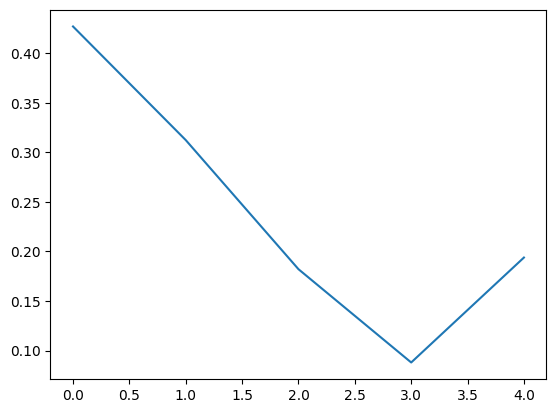

In [15]:
plt.plot(epoch_loss_random_search)

## Using LHS Sampling

In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from pyDOE2 import lhs
from tqdm import tqdm


# Function to normalize the parameters generated by LHS
def normalize_lhs_params(lhs_sample, param_ranges):
    normalized = np.zeros_like(lhs_sample)
    for i in range(lhs_sample.shape[1]):
        min_val, max_val = param_ranges[i]
        normalized[:, i] = min_val + lhs_sample[:, i] * (max_val - min_val)
    return normalized

# Assuming you have 10 parameters as in your original Fourier series
param_ranges = [(0, 1)] * 10  # 10 parameters, each with a range of (0, 1)


# Generate LHS samples
num_samples = 10
lhs_samples = lhs(len(param_ranges), samples=num_samples)
params = normalize_lhs_params(lhs_samples, param_ranges)

# Generate time series data
series_data = []
targets = []
for param in params:
    series = generate_series(fourier_gen, param)
    series_data.append(series)
    targets.append(objective(param))

# Convert to PyTorch tensors and create DataLoader
series_data = torch.tensor(np.array(series_data), dtype=torch.float32)
# Ensure series_data is in the shape [batch_size, seq_length, num_features]
series_data = series_data.reshape((10, -1, 1))  # 10 series, each with seq_length steps and 1 feature

# Normalize targets
target_scaler = MinMaxScaler(feature_range=(0, 1))
targets = target_scaler.fit_transform(np.array(targets).reshape(-1, 1))
targets = torch.tensor(targets, dtype=torch.float32)

train_data = TensorDataset(series_data, targets)
train_loader = DataLoader(dataset=train_data, batch_size=1)


# Neural Network Model Definition
class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TimeSeriesLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x needs to be of shape (batch, seq_len, features), here seq_len is 1 and features is input_size
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Take the last output for prediction
        return x

# Model Initialization
input_size = 1
hidden_size = 64
output_size = 1
model_LHS = TimeSeriesLSTM(input_size, hidden_size, output_size)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_LHS.parameters(), lr=0.001)

def train(model, criterion, optimizer, data_loader, epochs=5):
    model.train()
    epoch_losses = []  # List to store average loss per epoch

    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch+1}/{epochs}")

        for i, (series, target) in progress_bar:
            optimizer.zero_grad()
            outputs = model(series)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        avg_loss = epoch_loss / len(data_loader)
        epoch_losses.append(avg_loss)  # Store the average loss for this epoch
        print(f"Epoch [{epoch+1}/{epochs}] completed: Avg. Loss: {avg_loss:.4f}")

    return epoch_losses  # Return the list of average losses


epoch_losses = train(model_LHS, criterion, optimizer, train_loader)

Epoch 1/5: 100%|██████████| 10/10 [00:19<00:00,  1.95s/it, loss=0.00359]


Epoch [1/5] completed: Avg. Loss: 0.0960


Epoch 2/5: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it, loss=0.00901]


Epoch [2/5] completed: Avg. Loss: 0.0884


Epoch 3/5: 100%|██████████| 10/10 [00:20<00:00,  2.01s/it, loss=0.015] 


Epoch [3/5] completed: Avg. Loss: 0.0845


Epoch 4/5: 100%|██████████| 10/10 [00:19<00:00,  1.95s/it, loss=0.0207] 


Epoch [4/5] completed: Avg. Loss: 0.0820


Epoch 5/5: 100%|██████████| 10/10 [00:19<00:00,  1.98s/it, loss=0.026]  

Epoch [5/5] completed: Avg. Loss: 0.0801


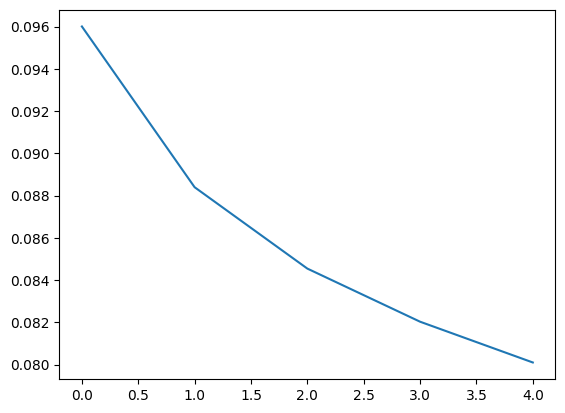

In [17]:
epoch_losses_lhs = epoch_losses
plt.plot(epoch_losses_lhs)

## Using Sobol Sequence

In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
# from pyDOE import lhs
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
import sobol_seq


# Function to normalize the parameters generated by LHS
def normalize_lhs_params(lhs_sample, param_ranges):
    normalized = np.zeros_like(lhs_sample)
    for i in range(lhs_sample.shape[1]):
        min_val, max_val = param_ranges[i]
        normalized[:, i] = min_val + lhs_sample[:, i] * (max_val - min_val)
    return normalized

# Assuming you have 10 parameters as in your original Fourier series
param_ranges = [(0, 1)] * 10  # 10 parameters, each with a range of (0, 1)

num_samples = 10

params = sobol_seq.i4_sobol_generate(len(param_ranges), num_samples)
params = normalize_lhs_params(params, param_ranges)

# Function to generate a single time series
def generate_series(fourier_gen, params):
    x = np.linspace(0, 400, int(400 / 0.002))
    laser_power = fourier_gen.fourier_series(x, params)[:150000]
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(laser_power.reshape(-1, 1))

# Generate time series data
series_data = []
targets = []
for param in params:
    series = generate_series(fourier_gen, param)
    series_data.append(series)
    targets.append(objective(param))

# Convert to PyTorch tensors and create DataLoader
series_data = torch.tensor(np.array(series_data), dtype=torch.float32)
# Ensure series_data is in the shape [batch_size, seq_length, num_features]
series_data = series_data.reshape((10, -1, 1))  # 10 series, each with seq_length steps and 1 feature

# Normalize targets
target_scaler = MinMaxScaler(feature_range=(0, 1))
targets = target_scaler.fit_transform(np.array(targets).reshape(-1, 1))
targets = torch.tensor(targets, dtype=torch.float32)

train_data = TensorDataset(series_data, targets)
train_loader = DataLoader(dataset=train_data, batch_size=1)


# Neural Network Model Definition
class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TimeSeriesLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x needs to be of shape (batch, seq_len, features), here seq_len is 1 and features is input_size
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Take the last output for prediction
        return x

# Model Initialization
input_size = 1
hidden_size = 64
output_size = 1
model_LHS = TimeSeriesLSTM(input_size, hidden_size, output_size)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_LHS.parameters(), lr=0.001)

def train(model, criterion, optimizer, data_loader, epochs=5):
    model.train()
    epoch_losses = []  # List to store average loss per epoch

    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch+1}/{epochs}")

        for i, (series, target) in progress_bar:
            optimizer.zero_grad()
            outputs = model(series)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        avg_loss = epoch_loss / len(data_loader)
        epoch_losses.append(avg_loss)  # Store the average loss for this epoch
        print(f"Epoch [{epoch+1}/{epochs}] completed: Avg. Loss: {avg_loss:.4f}")

    return epoch_losses  # Return the list of average losses


epoch_losses = train(model_LHS, criterion, optimizer, train_loader)

Epoch 1/5: 100%|██████████| 10/10 [00:20<00:00,  2.01s/it, loss=0.0163] 


Epoch [1/5] completed: Avg. Loss: 0.1371


Epoch 2/5: 100%|██████████| 10/10 [00:20<00:00,  2.01s/it, loss=0.0496]


Epoch [2/5] completed: Avg. Loss: 0.1039


Epoch 3/5: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it, loss=0.0742]


Epoch [3/5] completed: Avg. Loss: 0.0931


Epoch 4/5: 100%|██████████| 10/10 [00:20<00:00,  2.04s/it, loss=0.0777]


Epoch [4/5] completed: Avg. Loss: 0.0885


Epoch 5/5: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it, loss=0.0737]

Epoch [5/5] completed: Avg. Loss: 0.0852


## Using the BO code

In [19]:
params = [1,         0.31369773, 0, 0.1689344,  0.5357304,  0.5076246,
 0.58220387, 0.44922945, 0.81219506, 0.2288186 ]

def objective(params):
    # Create an instance of the simulator with the given parameters
    x = np.linspace(0, 400, int(400 / 0.002))
    fourier_gen = FourierSeriesGenerator_10(total_time=400, time_step=0.002)
    Laser_power = fourier_gen.fourier_series(x, params)
    result = simulator.simulate(Laser_power)
    # Since Bayesian Optimization typically minimizes,
    # if you want to maximize the output, return the negative of the result
    return torch.tensor(-result)

objective(params)

tensor(1614.9919, dtype=torch.float64)

In [20]:
def optimize(bounds, n_steps=10, epochs_per_step=1):
    gp = initialize_model()
    best_value = -float('inf')
    best_params = None

    param_history = []
    value_history = []
    uncertainty_history = []
    avg_epoch_loss = []

    all_series_data = []
    all_targets = []

    for i in tqdm(range(n_steps)):
        UCB = UpperConfidenceBound(gp, beta=1000)
        candidate, _ = optimize_acqf(UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20)
        candidate_numpy = candidate.detach().numpy().flatten()
        new_Y = objective(candidate_numpy).unsqueeze(0).unsqueeze(-1)

        variance = gp.posterior(candidate).variance
        uncertainty_history.append(variance.item())

        if new_Y.item() > best_value:
            best_value = new_Y.item()
            best_params = candidate_numpy

        param_history.append(candidate_numpy)
        value_history.append(new_Y.item())

        # Generate time series data for the current parameter set
        current_series = generate_series(fourier_gen, candidate_numpy)
        all_series_data.append(current_series)
        all_targets.append(objective(candidate_numpy))

        # Update the Gaussian Process model
        gp = SingleTaskGP(
            torch.cat([gp.train_inputs[0], torch.tensor(candidate_numpy.astype(np.float32)).unsqueeze(0)]),
            torch.cat([gp.train_targets.unsqueeze(-1).float(), new_Y.float()], dim=0)
        )
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

    # Normalize all targets
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    all_targets = target_scaler.fit_transform(np.array(all_targets).reshape(-1, 1))
    all_targets = torch.tensor(all_targets, dtype=torch.float32)

    # Convert all series data to PyTorch tensors
    all_series_data = torch.tensor(np.array(all_series_data), dtype=torch.float32)
    all_series_data = all_series_data.reshape((-1, 150000, 1))  # Reshape for LSTM input

    # Create DataLoader for all collected data
    train_data = TensorDataset(all_series_data, all_targets)
    print(all_series_data.shape)

    train_loader = DataLoader(dataset=train_data, batch_size=1)

    # Train the LSTM model on the collected data
    for epoch in range(epochs_per_step):
        epoch_losses = train(model_LHS, criterion, optimizer, train_loader)
        avg_epoch_loss.append(epoch_losses)

    return gp, best_params, best_value, param_history, value_history, uncertainty_history, avg_epoch_loss



def train(model, criterion, optimizer, data_loader, epochs=5):
    model.train()
    epoch_losses = []  # List to store average loss per epoch

    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch+1}/{epochs}")

        for i, (series, target) in progress_bar:
            optimizer.zero_grad()
            outputs = model(series)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        avg_loss = epoch_loss / len(data_loader)
        epoch_losses.append(avg_loss)  # Store the average loss for this epoch
        print(f"Epoch [{epoch+1}/{epochs}] completed: Avg. Loss: {avg_loss:.4f}")

    return epoch_losses  # Return the list of average losses

input_size = 10  # Assuming 10 parameters
bounds = torch.tensor([[0]*input_size, [1]*input_size], dtype=torch.float32)
optimized_model, best_params, best_value, param_history, value_history, uncertainty_history, epoch_losses = optimize(bounds)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fda1ff291b0>
Traceback (most recent call last):
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/data/zhq7531/envs/gamma/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
  0%|          | 0/10 [00:00<?, ?it/s]Exception ignored on calling ctypes callback function: <function _ThreadpoolIn

torch.Size([10, 150000, 1])


Epoch 1/5: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it, loss=0.0386]


Epoch [1/5] completed: Avg. Loss: 0.2291


Epoch 2/5: 100%|██████████| 10/10 [00:20<00:00,  2.10s/it, loss=0.0598]


Epoch [2/5] completed: Avg. Loss: 0.1960


Epoch 3/5: 100%|██████████| 10/10 [00:22<00:00,  2.21s/it, loss=0.0345]


Epoch [3/5] completed: Avg. Loss: 0.1603


Epoch 4/5: 100%|██████████| 10/10 [00:21<00:00,  2.19s/it, loss=0.00181]


Epoch [4/5] completed: Avg. Loss: 0.1216


Epoch 5/5: 100%|██████████| 10/10 [00:21<00:00,  2.20s/it, loss=0.0034]

Epoch [5/5] completed: Avg. Loss: 0.1081


In [21]:
epoch_loss_BO = epoch_losses[0]

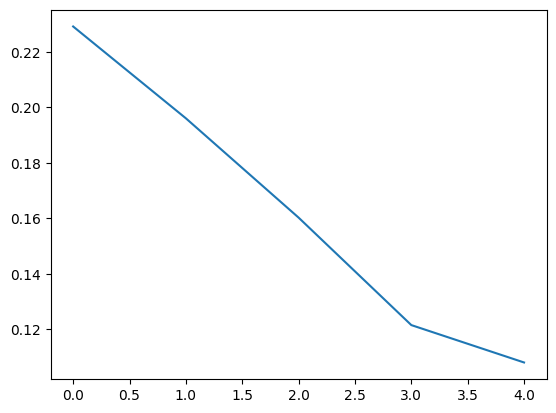

In [22]:
plt.plot(epoch_loss_BO)

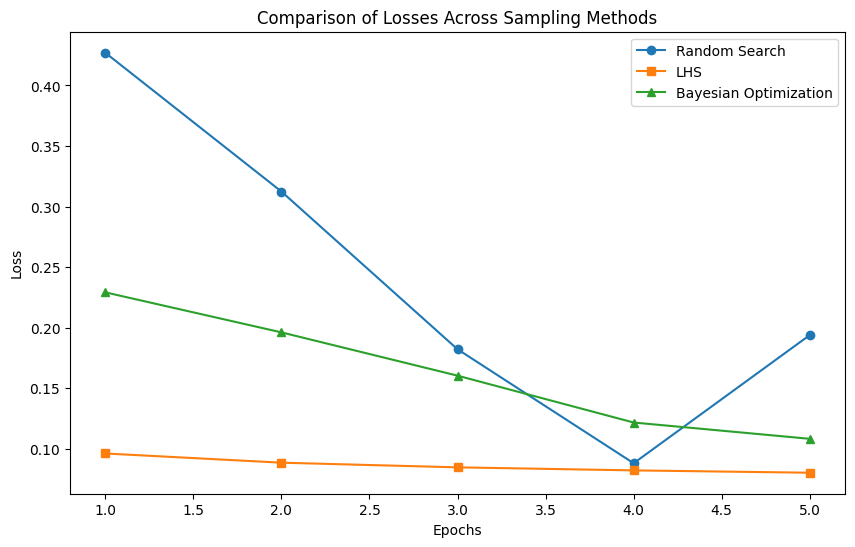

In [23]:
# The range for your epochs
epochs = range(1, len(epoch_loss_random_search) + 1)

# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_loss_random_search, marker='o', label='Random Search')
plt.plot(epochs, epoch_losses_lhs, marker='s', label='LHS')
plt.plot(epochs, epoch_loss_BO, marker='^', label='Bayesian Optimization')

# Adding titles and labels
plt.title('Comparison of Losses Across Sampling Methods')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Displaying the plot
plt.show()